In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
K = keras.backend

In [4]:
# First we need a custom layer to sample the Codings given mean and std

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean#exp is equivalent to std
    
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))    

In [5]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4423680/4422102 [==============================] - 0s 0us/step


In [6]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 7s 13ms/step - loss: 0.4438 - rounded_accuracy: 0.8154 - val_loss: 0.3508 - val_rounded_accuracy: 0.8925
Epoch 2/25
430/430 [==============================] - 5s 11ms/step - loss: 0.3462 - rounded_accuracy: 0.8952 - val_loss: 0.3366 - val_rounded_accuracy: 0.9028
Epoch 3/25
430/430 [==============================] - 5s 11ms/step - loss: 0.3341 - rounded_accuracy: 0.9038 - val_loss: 0.3309 - val_rounded_accuracy: 0.9088
Epoch 4/25
430/430 [==============================] - 5s 11ms/step - loss: 0.3290 - rounded_accuracy: 0.9082 - val_loss: 0.3271 - val_rounded_accuracy: 0.9110
Epoch 5/25
430/430 [==============================] - 5s 11ms/step - loss: 0.3255 - rounded_accuracy: 0.9113 - val_loss: 0.3249 - val_rounded_accuracy: 0.9151
Epoch 6/25
430/430 [==============================] - 5s 11ms/step - loss: 0.3242 - rounded_accuracy: 0.9131 - val_loss: 0.3253 - val_rounded_accuracy: 0.9096
Epoch 7/25
430/430 [==========================

In [7]:
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()

In [8]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

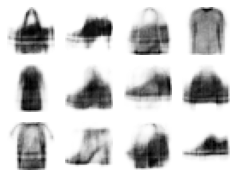

In [9]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

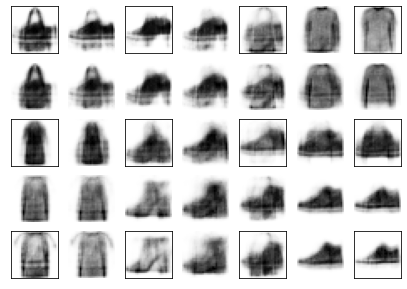

In [10]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")